(t = 2800 )
Training Layer:  2
Hidden Act: [ 0.0 , 0.26675612 , 3.7255147 ]
NextIn Act: [ -0.9453553 , -0.00045014493 , 2.857822 ]
Accuracy Per Layer: [0.8871999979019165, 0.8802000284194946]


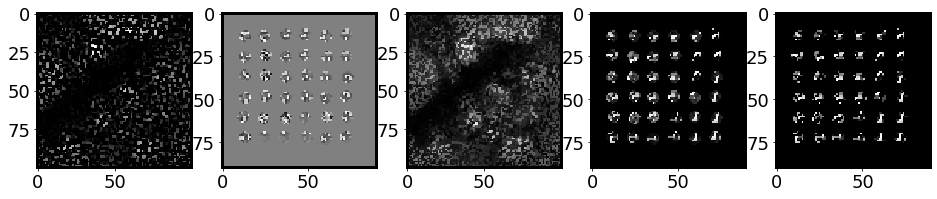

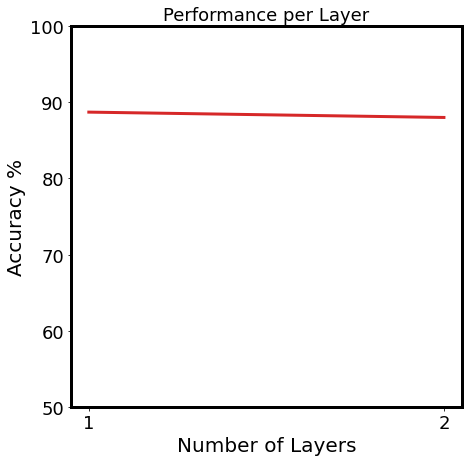

Epoch 1/10
3000/3000 [==============================] - 38s 12ms/step - loss: 0.6365 - accuracy: 0.7854
Epoch 2/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.5067 - accuracy: 0.8306
Epoch 3/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.4732 - accuracy: 0.8415
Epoch 4/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.4528 - accuracy: 0.8465
Epoch 5/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.4420 - accuracy: 0.8504
Epoch 6/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.4322 - accuracy: 0.8529
Epoch 7/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.4210 - accuracy: 0.8568
Epoch 8/10
3000/3000 [==============================] - 36s 12ms/step - loss: 0.4156 - accuracy: 0.8577
Epoch 9/10
 670/3000 [=====>........................] - ETA: 28s - loss: 0.3909 - accuracy: 0.8633

In [ ]:
%tensorflow_version 2.x
%matplotlib inline

!pip install import_ipynb # Should allow other jupiter notebooks to be loaded using import
!pip install tfa-nightly # Needed to get tensorflow image addons working (2.7.1 works)

# -*- coding: utf-8 -*-
"""
Created on Mon Nov/19/2020

@author: James Ryland

Experiment 1:
    This is an extension of experiment 1 to demonstrate that performance
generally decreses as more layers are added. For this demonstration we are
just using the SimpleOnly ICL model


For demonstration instructions see the end of the file...

"""

import import_ipynb

import ArborLayer
import SimpleICLayer as sicl
import SimpleComplexICLayer as scicl

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow.keras as keras
import numpy as np
from IPython.display import clear_output

from scipy.stats import ortho_group
from scipy.ndimage import label as RegionLabel
import gc

from datetime import date
from datetime import datetime

# Style for plotting
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

# Setup some basic font size thingies
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes' , linewidth =3)
plt.rc('lines', linewidth =3)
plt.rc('lines', markersize =10)

# Quick little function for getting prettier significant digits
def sigdigN(a, n):
    exp = np.floor(np.log10(a))
    return np.round(a, (-exp+n).astype(int)) 

def fileBase(quickNote):
    today = date.today()
    now = datetime.now()
    info = today.strftime("%b%d%y") +"_"+ now.strftime("%H%M")+"_"+quickNote
    return "EXP1_MNISTF_ByLayer"+info


def SphereNorm(x_im, depth = 36):
    x_im = tf.nn.l2_normalize(x_im, axis=[1,2,3])
    in_ln = tf.prod(x_im.shape[1:])
    scale = tf.sqrt(1/(depth/in_ln))  
    return x_im*scale

# A bit like a gain controll layer
class WindNormLayer( layers.Layer ):

    def __init__(self, width, alpha = 0.01, mult=1.0):    
        super().__init__()
        self.alpha = alpha
        self.mult = mult
        # Difference with local mean
        self.CC = sicl.CenterSurround(1, width)
        # Sum over local differences
        self.Gau = sicl.GaussianFilterLayer(width, 12, norm=False, pad = "REFLECT") # TRY THIS (I think there is an edge issue!)

    def call(self, in_im):
        dif = self.CC(in_im)
        var = self.Gau(tf.abs(dif))
        var = tf.nn.relu(var)   # Safety to ensure numerical approx 
                                # from gau does not leave negative numbers
        x = dif/(tf.sqrt(var)+ self.alpha)
        x = x*self.mult
        return x


class StrideLayer(layers.Layer):
    def __init__(self, stride = 1):  
        super().__init__()  
        self.stride=stride
    def call(self, in_im):
        if self.stride>1:
            in_im = in_im[:, ::self.stride, ::self.stride, :]
        return in_im

class ICLNet(tf.keras.Model):

    def __init__(self, deepLearn, useAxon=False, useComplex=False, name=None):
        super().__init__(name=name)

        # Current training state
        self.preTrain = True 
        #self.cc = sicl.CenterSurround(1, 4)
        #self.ccIC = sicl.CenterSurround(1, 4)
        self.cc = WindNormLayer(6, mult = 4.0)  # 4
        self.ccIC = WindNormLayer(6, mult = 4.0) # 1 worked pretty well ! other values have actually tanked so far!
                                                 # Try 4, it seems to work bettern with padding added!
        self.BatchNorm0 = layers.BatchNormalization(axis=[1,2]) #layers.BatchNormalization(axis=[1,2])
        self.BatchNorm1 = layers.BatchNormalization(axis=[1,2]) #layers.BatchNormalization(axis=[1,2])
        self.BatchNorm2 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm3 = layers.BatchNormalization(axis=[1,2])
        self.BatchNorm4 = layers.BatchNormalization(axis=[1,2])
        self.BatchNormOut = layers.BatchNormalization(axis=[1,2])
        self.BatchNormLS = [self.BatchNorm1, self.BatchNorm2, self.BatchNorm3, self.BatchNorm4]

        #self.lat  = [[.6, 2]  , [.75, 2.2], [.8, 2.4],  [1.0, 2.6]] 
        #self.depth = [6*6, 9*9, 12*12, 12*12]

        self.lat  = [[.6, 2], [.6, 2], [.6, 2],  [.6, 2]] 
        self.depth = [6*6, 6*6, 6*6, 6*6]
        #self.depth = [6*6, 7*7, 9*9, 10*10]  # 6x6 seems better

        self.ICL_LS = []
        #                                                                     fRate .3 is accross board works well
        if not useComplex:
            self.ICL1 = sicl.ProtoICLayer(100, self.depth[0], lat=self.lat[0], fRate=.3, nWeight=.0, axonLearn=useAxon, axRate=.1)
            self.ICL2 = sicl.ProtoICLayer(100, self.depth[1], lat=self.lat[1], fRate=.3, nWeight=.0, axonLearn=useAxon, axRate=.1)
            self.ICL3 = sicl.ProtoICLayer(100, self.depth[2], lat=self.lat[2], fRate=.3, nWeight=.0, axonLearn=useAxon, axRate=.1)
            self.ICL4 = sicl.ProtoICLayer(100, self.depth[3], lat=self.lat[3], fRate=.3, nWeight=.0, axonLearn=useAxon, axRate=.1)
            self.ICL_LS = [self.ICL1, self.ICL2, self.ICL3, self.ICL4]
        else:
            self.fRate = [.3, .3, .3, .3]
            self.ICL1 = scicl.ProtoICLayer(100, self.depth[0], lat=self.lat[0], latBias=[1, 1.6], fRate=self.fRate[0], nWeight=0)
            self.ICL2 = scicl.ProtoICLayer(100, self.depth[1], lat=self.lat[1], latBias=[1, 1.6], fRate=self.fRate[1], nWeight=0)
            self.ICL3 = scicl.ProtoICLayer(100, self.depth[2], lat=self.lat[2], latBias=[1, 1.6], fRate=self.fRate[2], nWeight=0)
            self.ICL4 = scicl.ProtoICLayer(100, self.depth[3], lat=self.lat[3], latBias=[1, 1.6], fRate=self.fRate[3], nWeight=0)
            self.ICL_LS = [self.ICL1, self.ICL2, self.ICL3, self.ICL4]


        self.Stride = StrideLayer(1)

        self.Flat = layers.Flatten()
        self.Dense1 = layers.Dense(10, activation='relu')
        self.Dense2 = layers.Dense(10, activation='relu')
        self.Dense3 = layers.Dense(10, activation='relu')
        self.Dense4 = layers.Dense(10, activation='relu')
        self.Dense_LS = [self.Dense1, self.Dense2, self.Dense3, self.Dense4]
        
        #self.Drop = layers.Dropout(.7)
        self.Drop = layers.Dropout(.3)


        # Output the activity image
        self.imOut = False
        self.deepLearn = deepLearn

        # set the training layer
        self.trainLayer = 0

    def call(self, x, training=None):
        
        # Normalize and center
        # Try switching!!
        
        x = sicl.ItemBoxNorm(x)
        x = self.cc(x)

        if self.preTrain:
            #x = self.BatchNorm0(x, training=True)
            for l in range(0, self.trainLayer+1):
                x = self.ICL_LS[l]      (x, training=(l==self.trainLayer))
                x = self.ccIC(x)
                x = self.Stride(x)
                #x = sicl.ItemBoxNorm(x) 
                #x = self.BatchNormLS[l] (x, training=(l==self.trainLayer))
        else:
            #x = self.BatchNorm0(x, training=training)
            for l in range(0, self.trainLayer+1):
                x = self.ICL_LS[l]      (x, training=False)
                x = self.ccIC(x)
                x = self.Stride(x)
                #x = sicl.ItemBoxNorm(x) 
                #x = self.BatchNormLS[l] (x, training=training)

            x = self.BatchNormLS[self.trainLayer] (x, training=training) # (This is really important for performance)
            x = self.Drop(x, training=training)
            x = self.Flat(x)
            if not self.imOut:
                if not self.deepLearn:
                    x = tf.stop_gradient(x)
                x = self.Dense_LS[self.trainLayer](x)
        return x



# A quick plot for the results of the experiment
def plotLayerPerf(acc_list):

    acc_list = np.array(acc_list)*100

    fig = plt.figure(figsize=[7,7])
    ax1 = fig.add_subplot(1,1,1)
    x_pos = np.arange(len(acc_list))+1
    line1 = ax1.plot( x_pos, acc_list, color="tab:red", label="Accuracy")
        
    #ax1.legend()
    ax1.set_title('Performance Per Layer')
    ax1.set_xlabel('Number of Layers')
    ax1.set_ylabel('Accuracy %')

    ax1.set_ylim([50, 100])    

    ax1.set_xticks(x_pos)
    #ax1.set_xticklabels(["Layer 1","Layer 2","Layer 3","Layer 4"], rotation=90)

    return fig

# Quick little test for a shallow ProtoICL net...
def perfPerLayer(useAxon=False, useComplex=False):

    fashion_mnist = keras.datasets.fashion_mnist
    labelNames = [  "top", "trouser", "pullover", "dress", "coat",
	                "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    #fashion_mnist = keras.datasets.mnist
    #labelNames = [  "0", "1", "2", "3", "4",
	#                "5", "6", "7", "8", "9"]
    
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images[:,:,:,np.newaxis]
    test_images = test_images[:,:,:,np.newaxis]

    #cifar10 = keras.datasets.cifar10
    #(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    #train_images = np.sum(train_images, axis=3, keepdims=True)
    #test_images = np.sum(test_images, axis=3, keepdims=True)

    # Setup label format correctly
    train_labels = keras.utils.to_categorical(train_labels, 10)
    test_labels = keras.utils.to_categorical(test_labels, 10)

    # Normalize images
    train_images = (train_images/255.0).astype(np.float32)
    #train_images = ItemBoxNorm(train_images).numpy()
    test_images = (test_images/255.0).astype(np.float32)
    #test_images = ItemBoxNorm(test_images).numpy()
    
    # Setup Model
    model = []
    stepNum = []


    model = ICLNet(deepLearn=False, useAxon=useAxon, useComplex=useComplex)


    # Setup temporal augmentation (I think these are good settings!)
    batch = 20
    episodeLength = 10
    batch = 10

    Picker = sicl.ItemPicker(batch, train_labels, 5, 10)

    Aug =sicl.TemporalAugmentLayer(batch, episodeLength, shiftSpeed=.4, phiSpeed=.4, 
                                   speedMultiplier = .4, momentum=.99, changeEachStep=True)
    
    # Pretraining Loop
    model.preTrain = True
    
    # Number of layers
    numLayers = 4

    # Info to keep 
    test_acc_ls = []
    train_acc_ls = []

    # Write some header info
    fileName = fileBaseStr +".txt"
    file = open( fileName,"a")
    text = ""
    text = text + "NOTE:\n"
    text = text + note
    text = text + "MODEL INFO:  MNIST\n"
    text = text + "DeepLearn="+str(model.deepLearn)+"\n"
    text = text + "NumLayers="+str(numLayers)+"\n"
    text = text + "Lat="+str(model.lat)+"\n"
    text = text + "depth="+str(model.depth)+"\n"
    file.writelines(text) 
    file.close()


    # Switch which layer is training
    for l in range(numLayers):
        
        model.trainLayer = l

        # Right this would have almost no impact...
        #Picker.Settings( 10-l*2, 10+l)
        
        for i in range(2000):
            
            # Set visualization layer
            dispICL = model.ICL_LS[model.trainLayer]

            # Pick and augment input data
            #picks = np.random.choice(train_images.shape[0], size=[batch])
            picks = Picker()

            in_imRaw = train_images[picks,:,:,:]
            in_im = Aug(in_imRaw)
            
            # Run the model on the batch
            out_im = model(in_im, training=False)
            
            
            if np.mod(i,200)==0:
                
                clear_output()
                
                print("(t =",i,")")
                print("Training Layer: ", model.trainLayer)
                hid = dispICL.last_Hid[0,:,:,:]
                nextIn = out_im
                print("Hidden Act: [", np.min(hid) ,",", np.mean(hid),",", np.max(hid) ,"]")
                print("NextIn Act: [", np.min(nextIn) ,",", np.mean(nextIn),",", np.max(nextIn) ,"]")
                print("Accuracy Per Layer:", test_acc_ls)

                fig = plt.figure(figsize=[12,4])
                ax = fig.add_subplot(1, 2, 1)
                ax.imshow(np.squeeze(dispICL.last_Hid[0,:,:,:]), cmap='gray', interpolation='nearest')
                
                ax = fig.add_subplot(1, 2, 2)
                dispIm = dispICL.Arb.projectWeights(sampleInterval=15, projectInterval=12, center=True) 
                ax.imshow(np.squeeze(dispIm), cmap='gray', interpolation='nearest')

                plt.pause(.1)

        # there is a memory leak in model.fit and model.evaluate
        # so we need to force python to get rid of unused variables
        gc.collect()

        # Set last layer to deep learn
        supEpochs = 20
        #if l == (numLayers-1):
        #    model.deepLearn = True 
        #    supEpochs = 300

        # compile sets the training paramaeters
        model.preTrain = False
        # learning rate = .005 is really good
        lRates = [.005, .01, .01, .01]
        #lRates = [.005, .005, .005, .005]
        #opt = tf.keras.optimizers.SGD(learning_rate=lRates[l]) # This one has shown good performance
        #opt = tf.keras.optimizers.Adam(learning_rate=.00001)  # this is just an experiment...
        opt = tf.keras.optimizers.Adam(learning_rate=.0001)  # same as simple complex
        model.compile(  opt,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                run_eagerly=False,
                metrics=['accuracy'])

        #                                            15
        model.fit(train_images, train_labels, epochs=supEpochs, batch_size=20)
        test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
        print('\nTest accuracy:', test_acc)
        test_acc_ls.append(test_acc)

        
        test_pred = model.predict(test_images)

        # Write detailed info to the file
        classReportL = classification_report(np.argmax(test_pred,axis=-1), np.argmax(test_labels,axis=-1), target_names=labelNames)
        conf = tf.math.confusion_matrix(np.argmax(test_labels,1), np.argmax(test_pred,1))
        confReportL = np.round(conf/np.sum(conf, axis=1)*100, 0)
        
        #   Save the results of EXP1 and Record Results:
        #--------------------------------------------------
        file = open( fileName,"a")
        text = ""
        text = text + "----------------------------LAYER("+str(l+1)+") \n"
        text = text + "Test Accuracy: " + str( np.round( test_acc*100, 2)) + "% \n\n"
        text = text + "Detailed Report: \n"
        text = text + classReportL
        text = text + "\nConfusion Matrix:\n"
        text = text + str(confReportL)
        text = text + "\n\n"        
        file.writelines(text) 
        file.close()

        print(text)

        # Set the model to train again!
        model.preTrain = True

    fig = plotLayerPerf(test_acc_ls)
    fig.savefig( fileBaseStr + "_Exp1_PerLayerPerf" + ".png", dpi=300 )


#note = "testing model with only simple cells"
#fileBaseStr = fileBase("Simple")
#perfPerLayer() 

#note = "testing model with axonal learning"
#fileBaseStr = fileBase("Axon")
#perfPerLayer(useAxon = True) 

note = "testing model with simple cells and complex cells"
fileBaseStr = fileBase("Complex")
perfPerLayer(useComplex=True) 

# Trying out strides, next try larger windows without strides...
# May also try mean-pooling... but this may not workout...
# A smaller model may allow for better experimentation with window sizes....


"""
DEMONSTRATION INSTRUCTIONS:
In the google colab enviornment make sure you have added the following files
to the environment:
- ArborLayer.ipynb 
- SimpleICLayer.ipynb
- SimpleComplexICLayer.ipynb

An easy way to include a file is to download the entire repository to you computer
locally, then when nescessary drag and drop the file on your computer into the
Files tab in google colab.

Also make sure that you have selected a GPU environment as this is an intensive 
simulation that will run much faster with GPU support enable. (note that 
switching to a GPU environment does not carry over included files so you will 
need to reload them)

When this is done simple recompile the file and it should go through a
demonstration of the full ICL model trained with 4 layers on MNIST-F.

Note: Some of these simulations can take a while to run so go grab a coffee or
      Something.  
"""






